In [10]:
import numpy as np
import pandas as pd
from scipy import stats

# sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import mean_absolute_error, r2_score

# torch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

# graphics imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#catboost
from catboost import CatBoostRegressor

#lightgbm
from lightgbm import LGBMRegressor

#xgboost
from xgboost import XGBRegressor

from utilities import create_stratified_folds, train_cv_catboost, train_test_fit_like_models, setup_logger

import json

In [26]:
immunology = pd.read_excel('./data/media-1.xlsx', skiprows=1)
features = immunology.columns[:-1]
target = ['Age']
target_name = 'Age'

# Age histogram

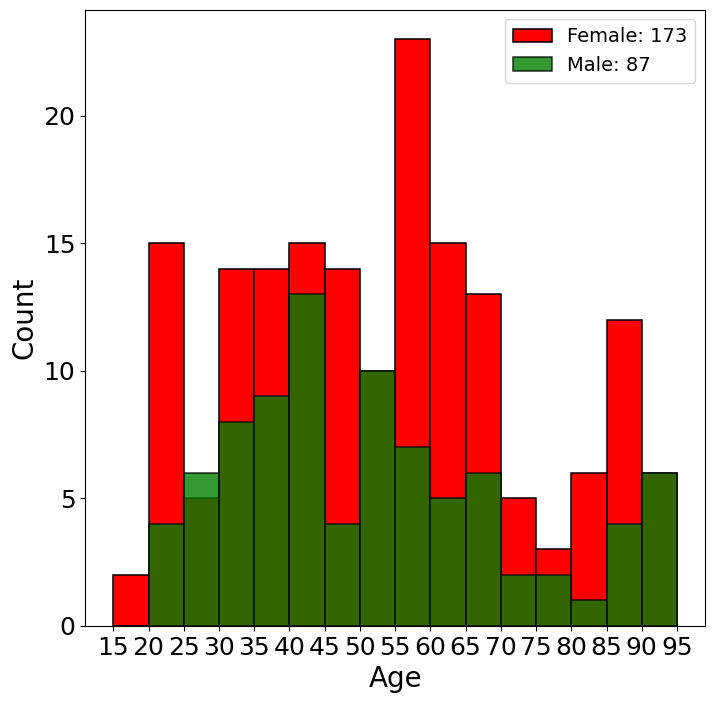

In [27]:
plt.figure(figsize=(8, 8))
plt.hist(immunology['Age'].loc[immunology['Sex'] == 'F'], bins=np.arange(15, 100, 5), color='red', edgecolor='black', linewidth=1.1, label=f"Female: {len(immunology[immunology['Sex'] == 'F'])}")
plt.hist(immunology['Age'].loc[immunology['Sex'] == 'M'], bins=np.arange(15, 100, 5), color='green', alpha = 0.8, edgecolor='black', linewidth=1.1, label=f"Male: {len(immunology[immunology['Sex'] == 'M'])}")
plt.xticks(np.arange(15, 100, 5), fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel('Age', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Correlation matrices

In [ ]:
pearson_corr_df = pd.DataFrame(columns=immunology.copy().drop(['index', 'Sex'], axis=1).columns).astype(float)
spearman_corr_df = pd.DataFrame(columns=immunology.copy().drop(['index', 'Sex'], axis=1).columns).astype(float)
pearson_pvalue_df = pd.DataFrame(columns=immunology.copy().drop(['index', 'Sex'], axis=1).columns).astype(float)
spearman_pvalue_df = pd.DataFrame(columns=immunology.copy().drop(['index', 'Sex'], axis=1).columns).astype(float)

for col1 in immunology:
    for col2 in immunology:
        if pd.api.types.is_numeric_dtype(immunology[col1]) and pd.api.types.is_numeric_dtype(immunology[col2]):
            r, p = stats.pearsonr(immunology[col1], immunology[col2])
            spr, sp = stats.spearmanr(immunology[col1], immunology[col2])
            pearson_corr_df.loc[col1, col2] = round(r, 2)
            spearman_corr_df.loc[col1, col2] = round(spr, 2)
            pearson_pvalue_df.loc[col1, col2] = round(-np.log10(p), 2)
            spearman_pvalue_df.loc[col1, col2] = round(-np.log10(sp), 2)

## Pearson

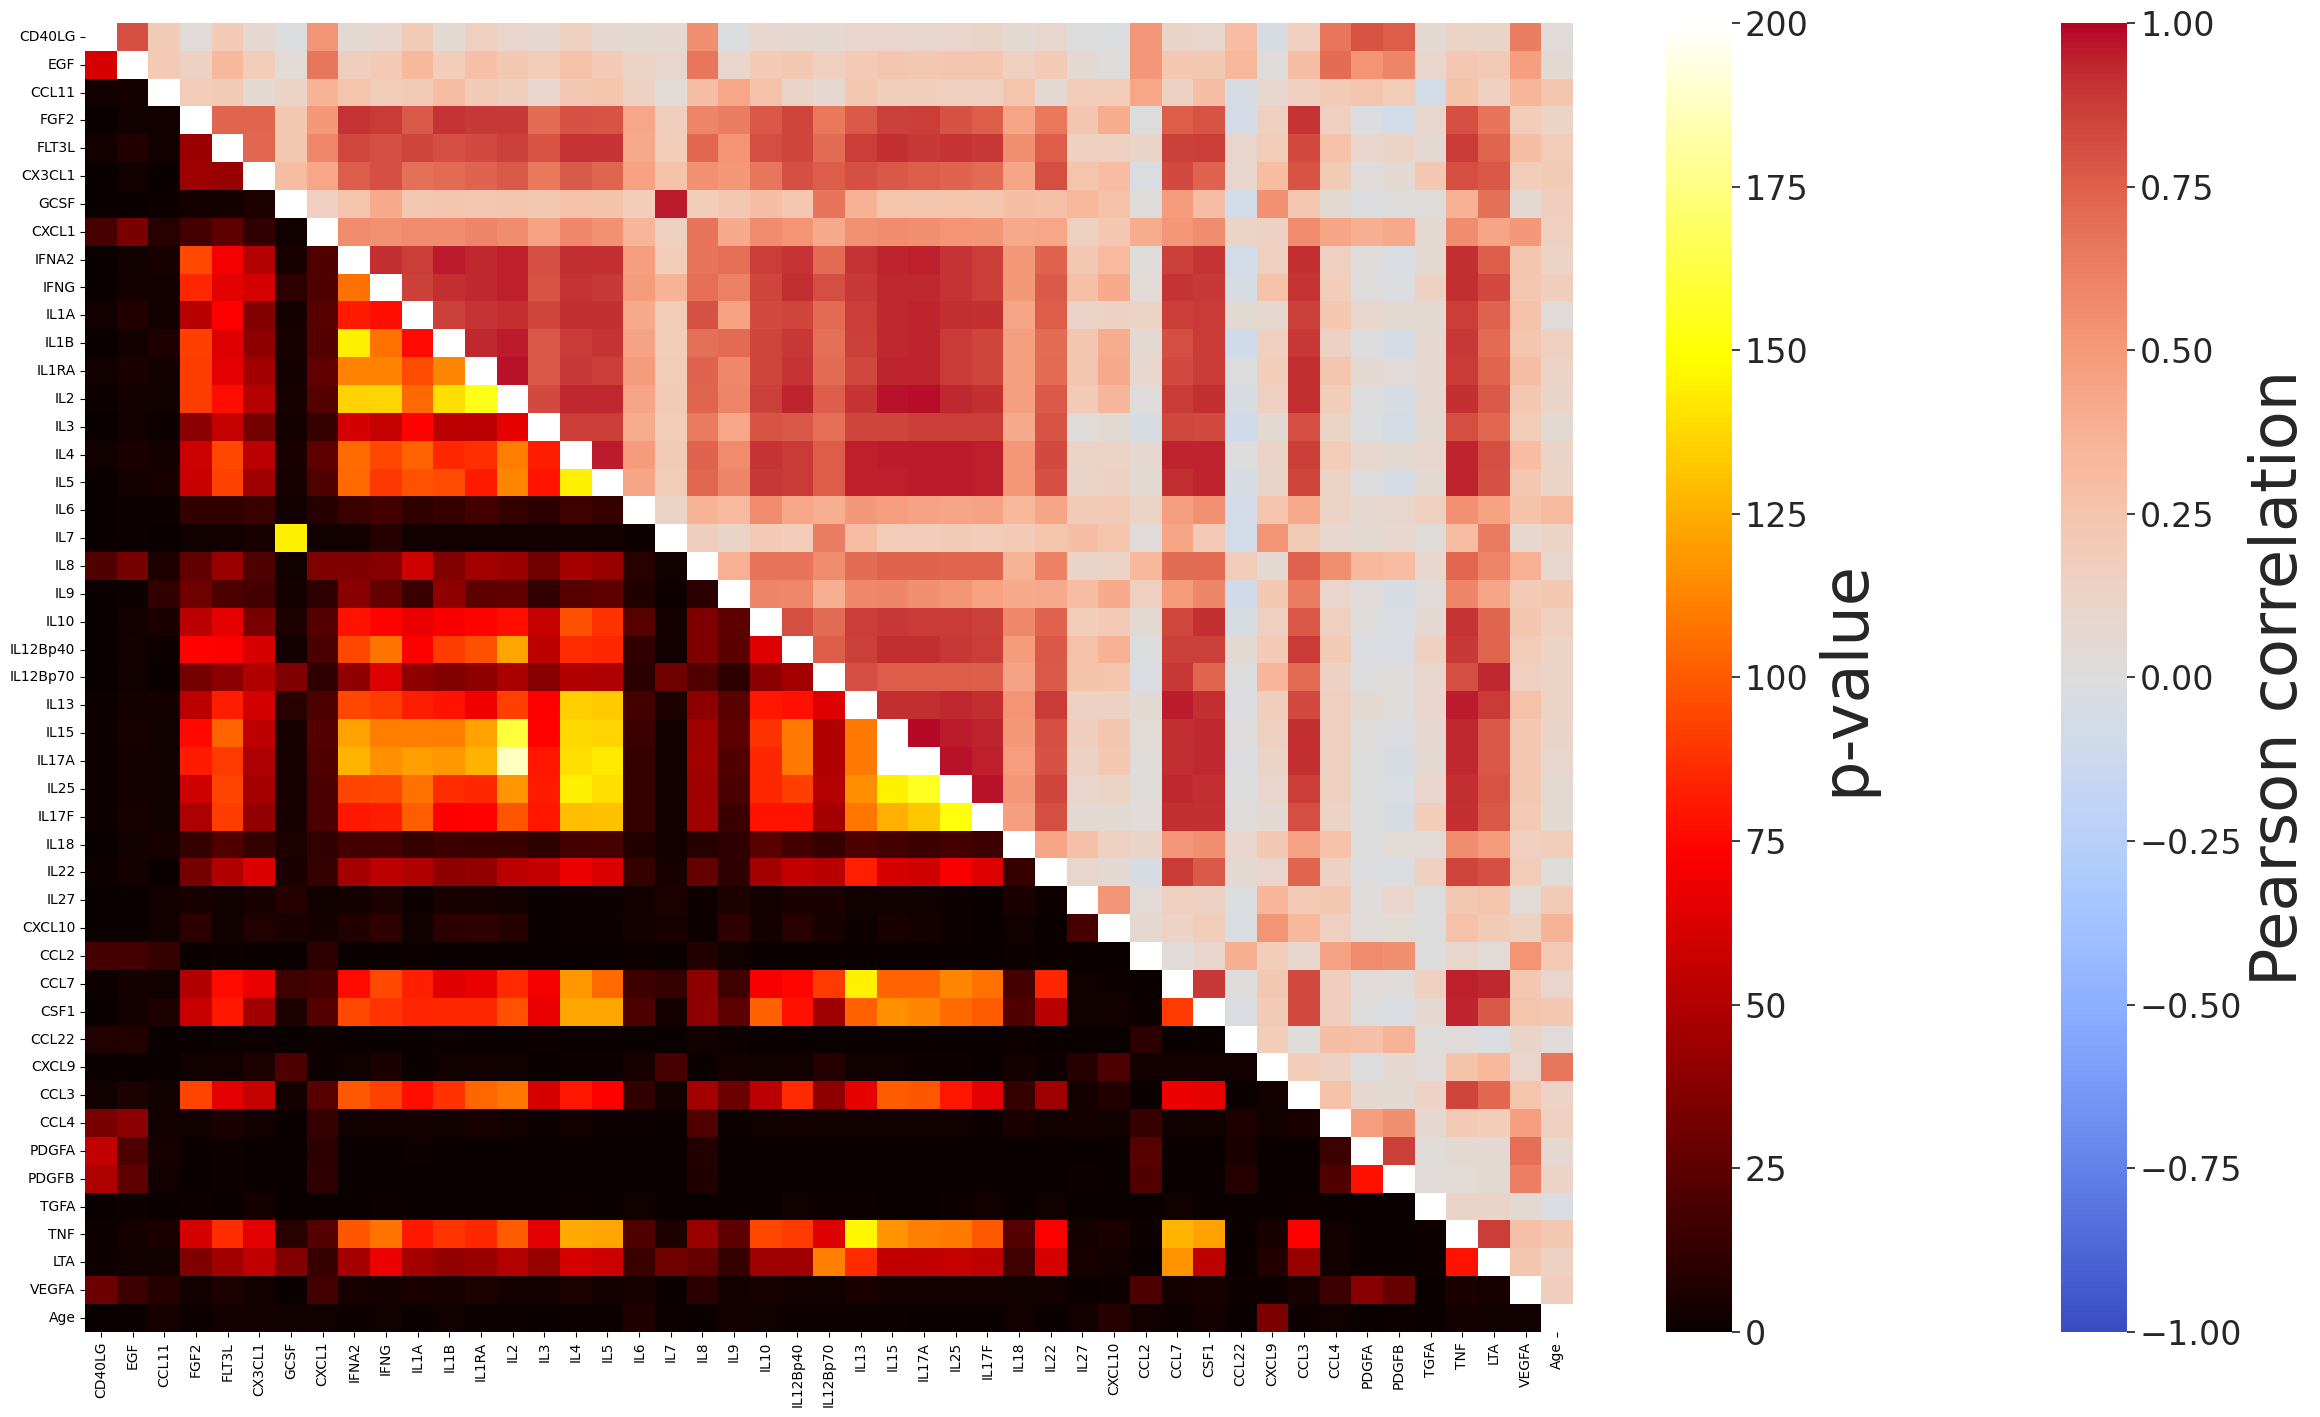

In [29]:
fig, ax = plt.subplots(figsize=(30, 17))

sns.set(font_scale=2.5)

mask = np.zeros_like(pearson_corr_df, dtype=np.bool_)
mask[np.tril_indices_from(mask)] = True

heatmap1 = sns.heatmap(pearson_corr_df, annot=False, cmap='coolwarm', square=False, vmin=-1, vmax=1, mask=mask, ax=ax)

cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Pearson correlation', fontsize=46)
cbar.ax.tick_params(labelsize=24)

mask = np.zeros_like(pearson_corr_df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

heatmap2 = sns.heatmap(pearson_pvalue_df, annot=False, cmap='hot', square=False, vmin=0, vmax=200, mask=mask, ax=ax)

cbar = ax.collections[1].colorbar
cbar.ax.set_ylabel('p-value', fontsize=46)
cbar.ax.tick_params(labelsize=24)

plt.show()


## Spearman

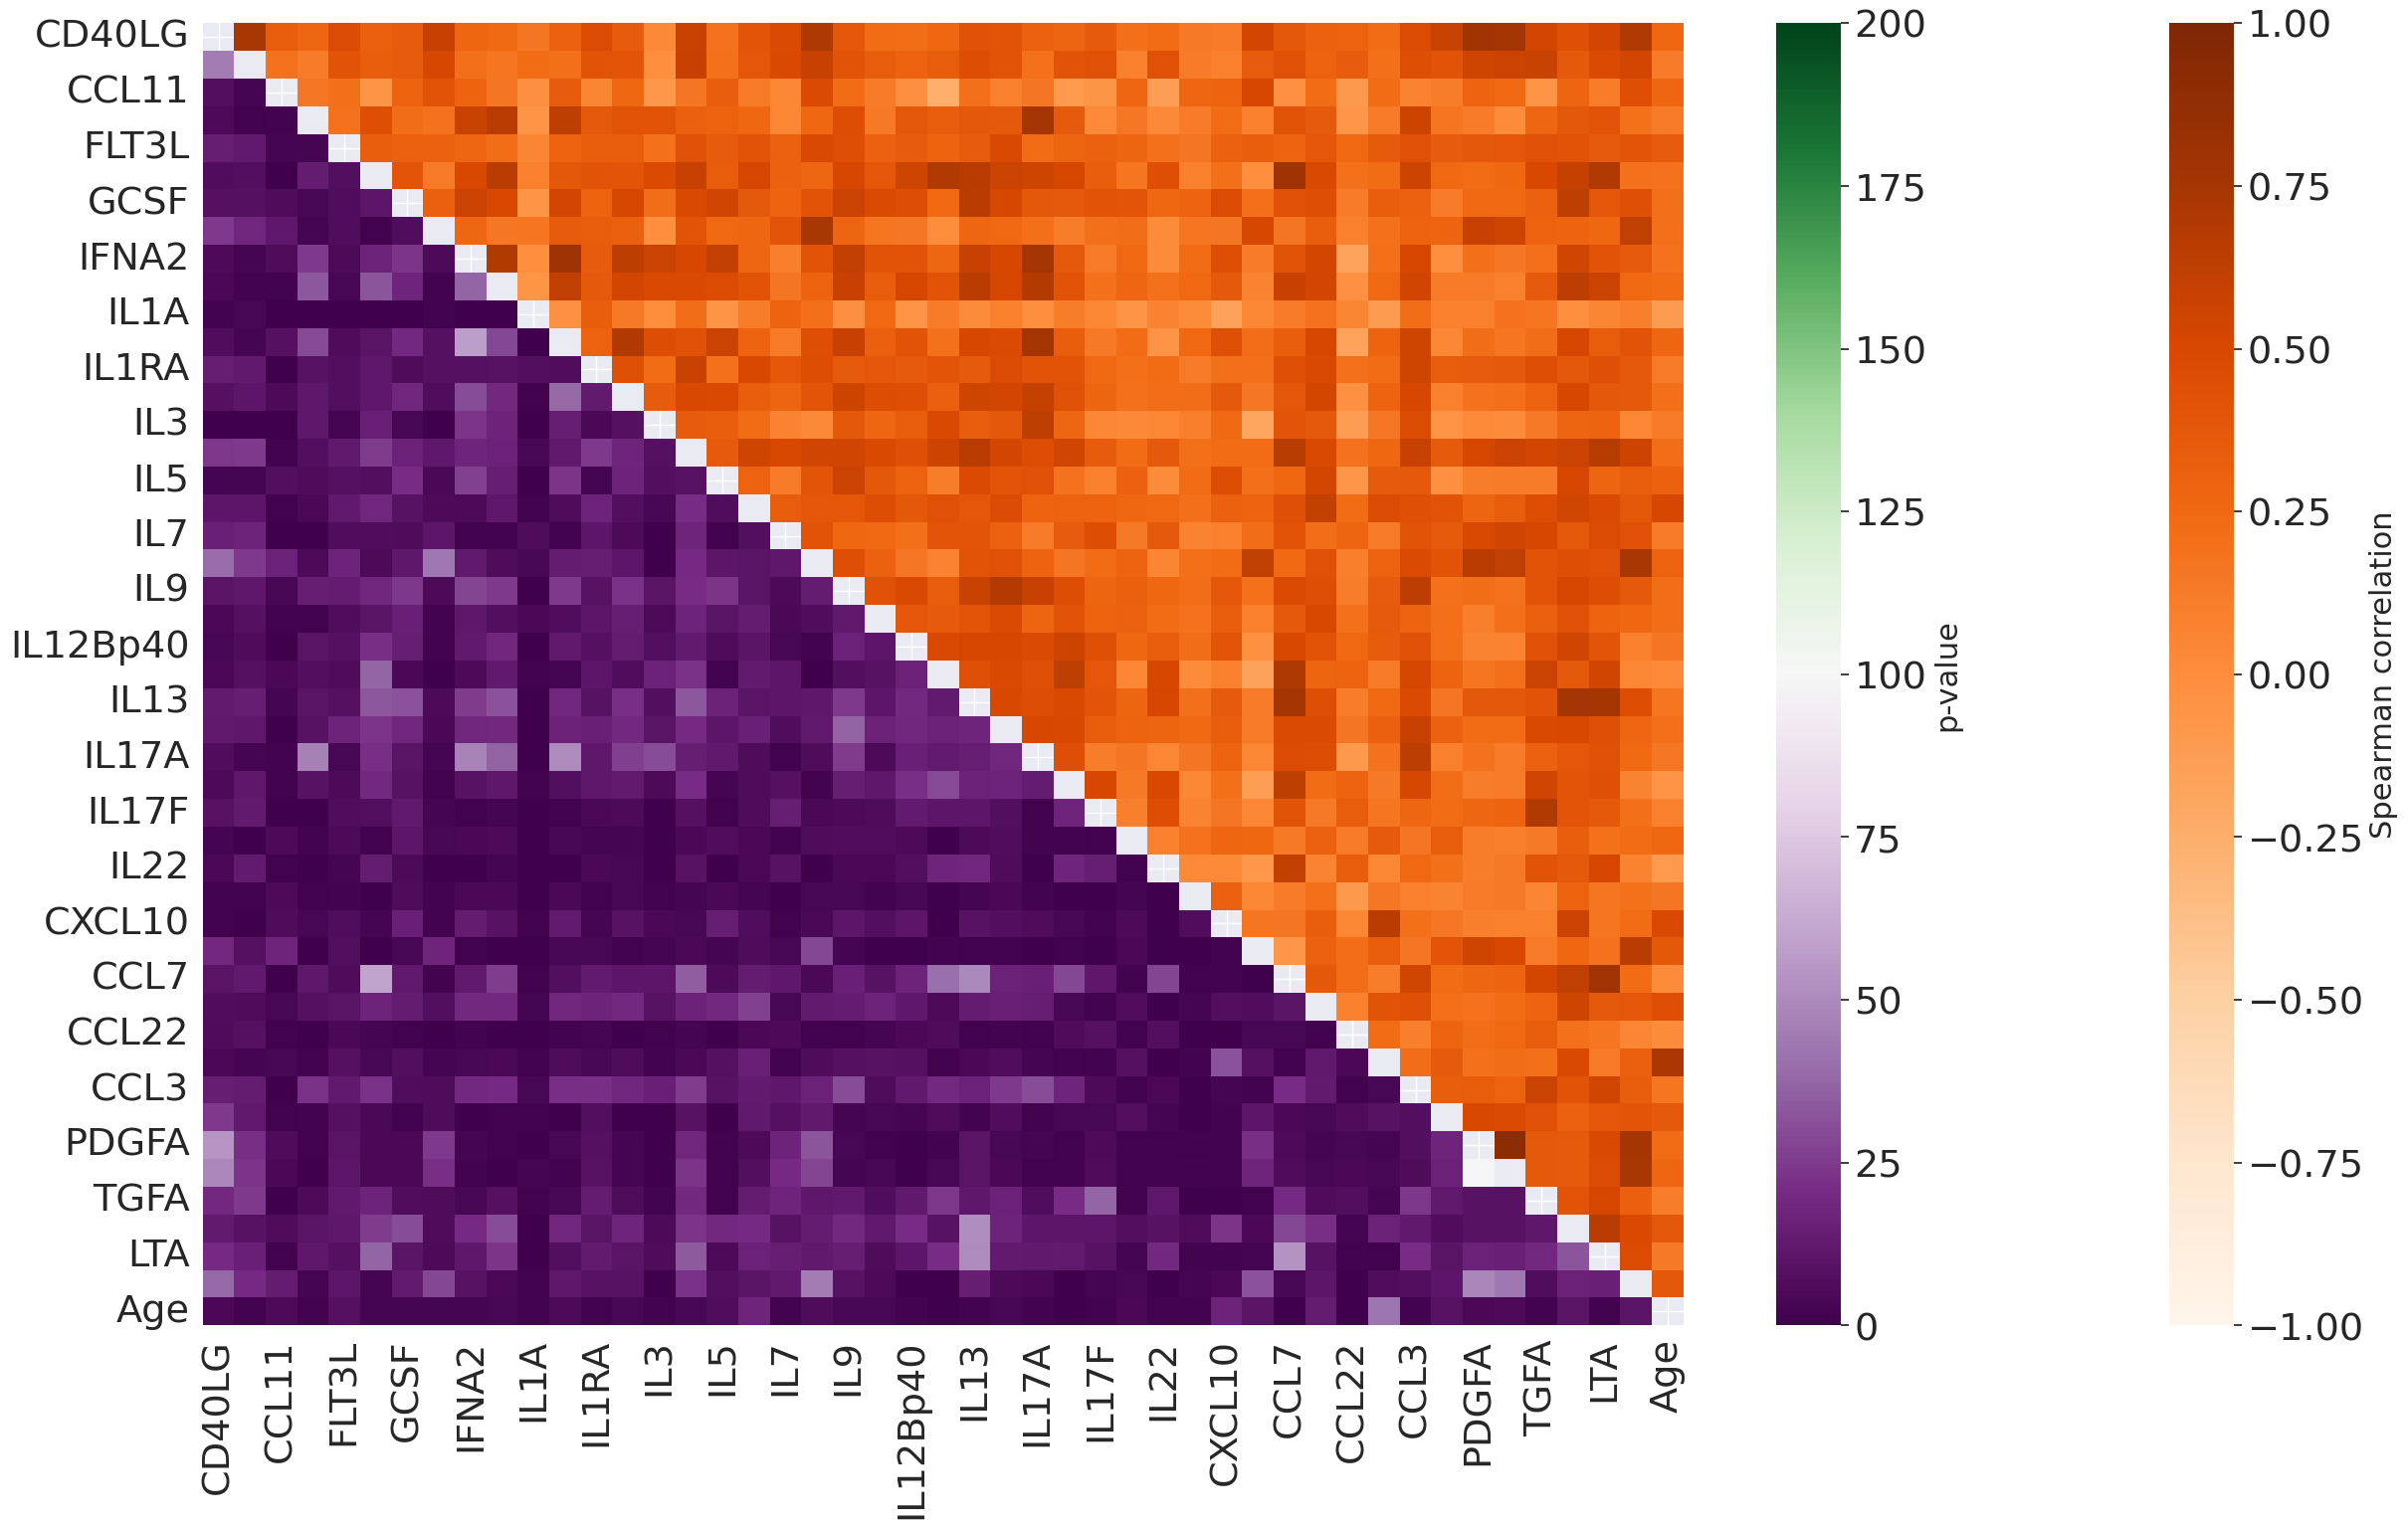

In [30]:
fig, ax = plt.subplots(figsize=(30, 17))

mask = np.zeros_like(spearman_corr_df, dtype=np.bool_)
mask[np.tril_indices_from(mask)] = True

heatmap1 = sns.heatmap(spearman_corr_df, annot=False, cmap='Oranges', square=False, vmin=-1, vmax=1, mask=mask, ax=ax)

cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Spearman correlation', fontsize=22)

mask = np.zeros_like(pearson_corr_df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

heatmap2 = sns.heatmap(spearman_pvalue_df, annot=False, cmap='PRGn', square=False, vmin=0, vmax=200, mask=mask, ax=ax)

cbar = ax.collections[1].colorbar
cbar.ax.set_ylabel('p-value', fontsize=22)

plt.show()

# Distribution

In [31]:
immunology, bins_range = create_stratified_folds(immunology, target_name, n_s=6, n_grp=5)

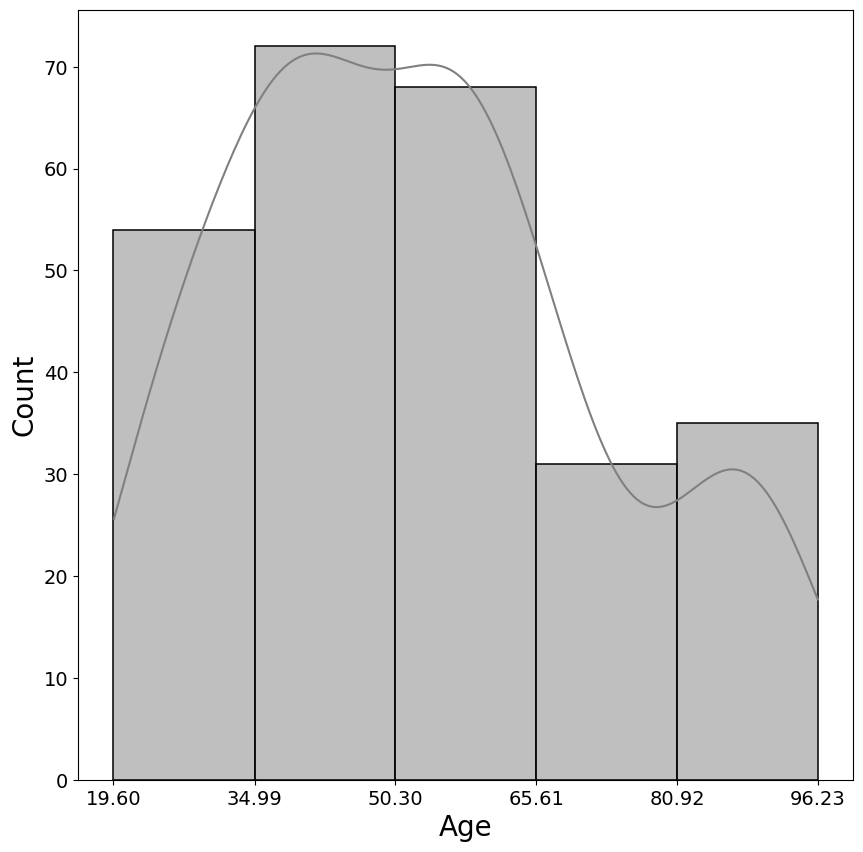

In [32]:
plt.figure(figsize=(10, 10))
mpl.rcParams.update(mpl.rcParamsDefault)

sns.set_palette(['grey'])

sns.histplot(immunology[target], bins=bins_range, kde=True, linewidth = 1.1, label=f"immunology, samples: {len(immunology)}", legend=None)
plt.xticks(np.array(bins_range), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Age', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.show()

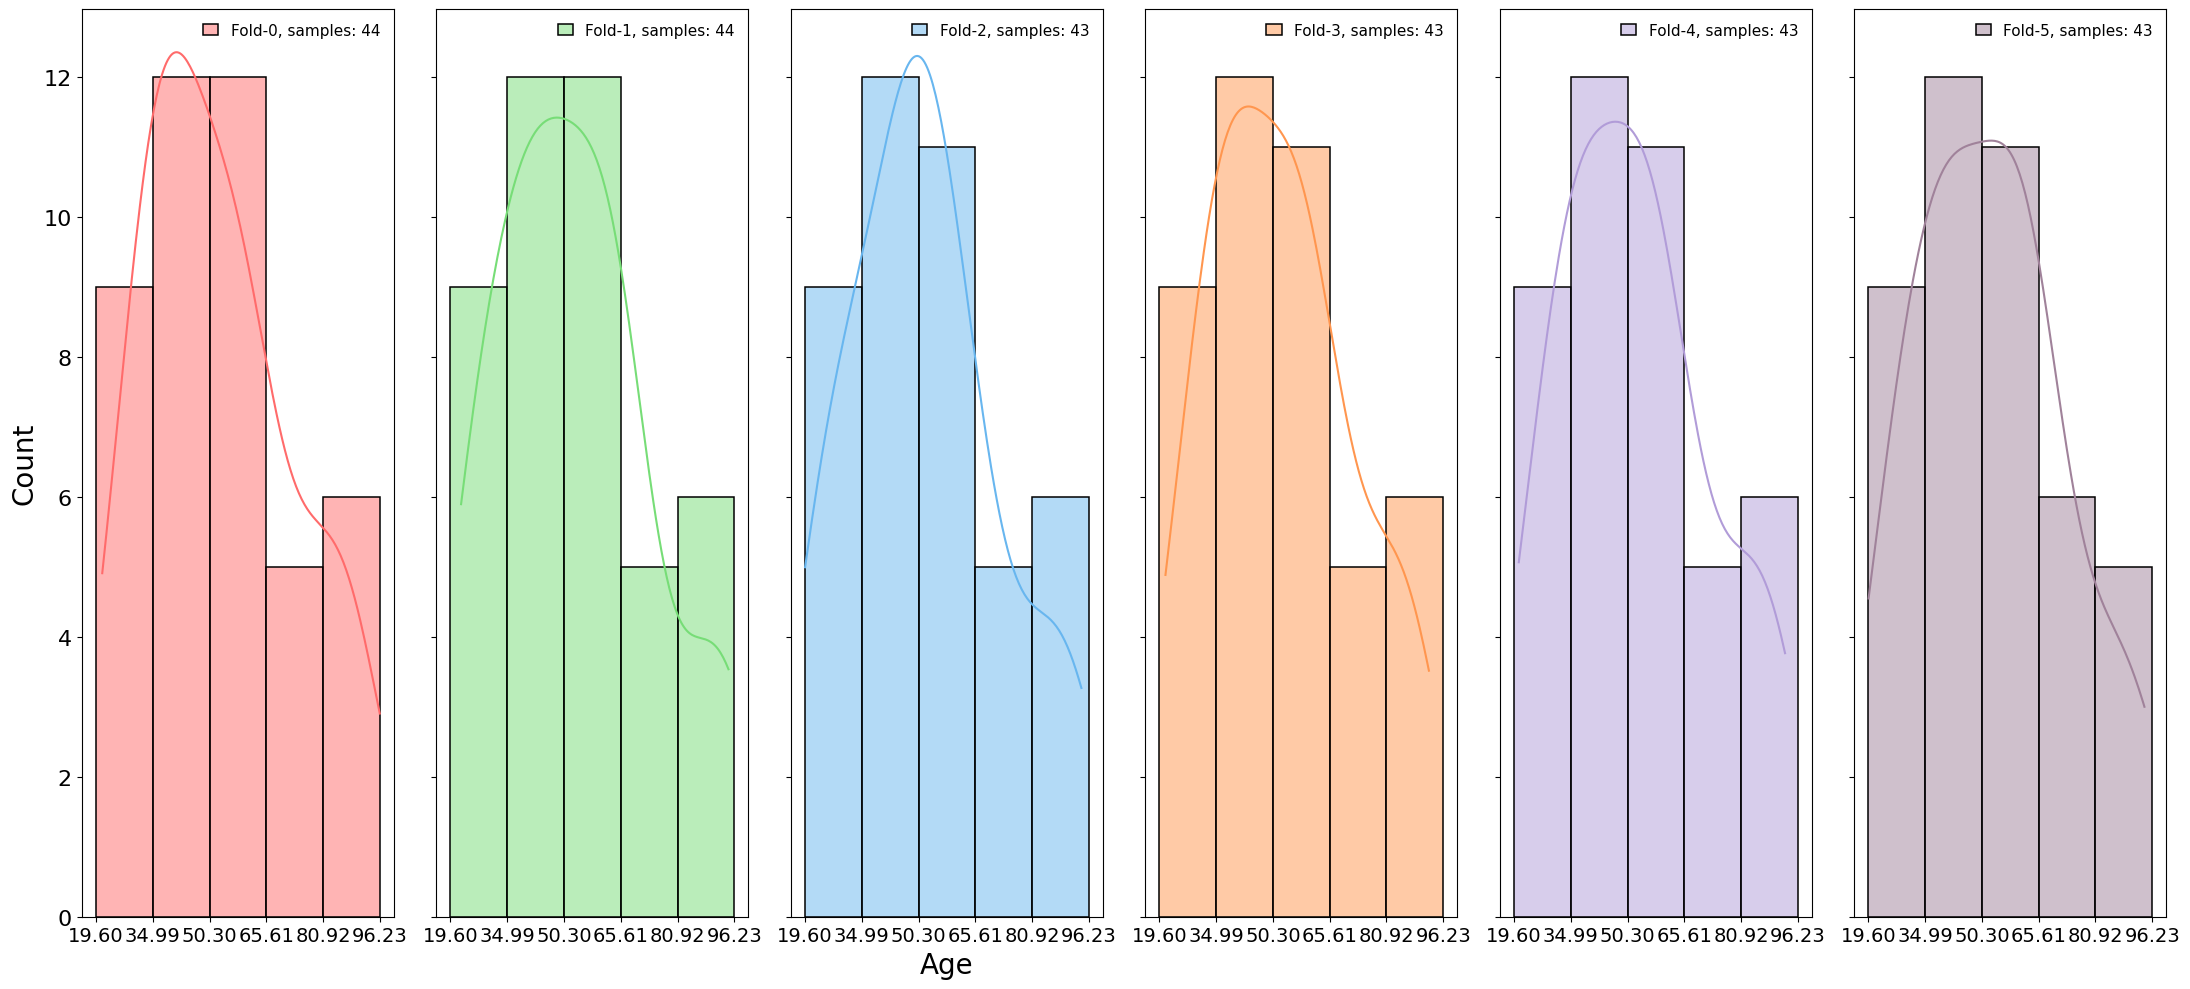

In [33]:
fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(22, 10))
palettes = [['#ff6b6b'], ['#77dd77'], ['#68b6ef'], ['#ff964f'], ['#b19cd8'], ['#a0829a']]
plt.xticks(np.array(bins_range))
for i, ax in enumerate(axs):
    sns.set_palette(palettes[i])
    sns.histplot(immunology[immunology.Fold == i][target], bins=bins_range, kde=True, linewidth=1.1, ax=ax, label=f"Fold-{i}, samples: {len(immunology[immunology.Fold == i])}")
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)
    if i == 0:
        ax.set_ylabel('Count', fontsize=20)
    if i == 2:
        ax.set_xlabel('Age', fontsize=20)
    ax.legend(frameon=False, handlelength=1, fontsize=11)
    plt.tight_layout()
plt.show()

# Stack diagram

/tmp/ipykernel_36345/3713663126.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(immunology.loc[immunology['Fold'] == 5], x='Age', bins=np.arange(15, 100, 15), edgecolor='black', linewidth=1, ax=axs[1], color='cyan', palette='pastel', label='Test')


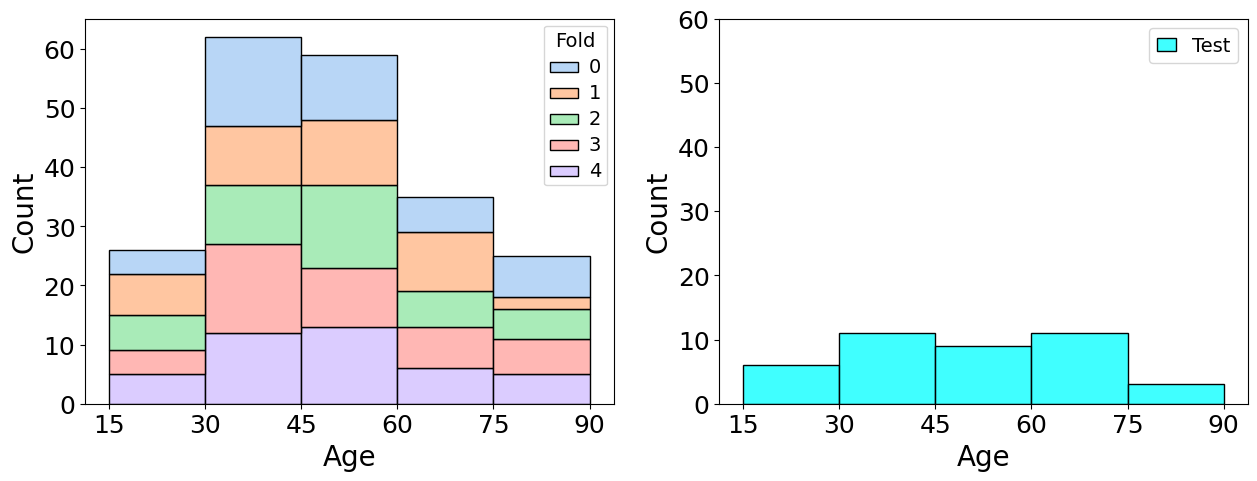

In [34]:
series = immunology.loc[immunology['Fold'] != 5]['Fold'].astype(int)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
gfg = sns.histplot(immunology, x='Age', hue=series, bins=np.arange(15, 100, 15), multiple='stack', edgecolor='black', ax=axs[0], linewidth=1, palette='pastel')
for i, elem in enumerate(gfg.get_legend().get_texts()):
    elem.set_text(i)
sns.histplot(immunology.loc[immunology['Fold'] == 5], x='Age', bins=np.arange(15, 100, 15), edgecolor='black', linewidth=1, ax=axs[1], color='cyan', palette='pastel', label='Test')

axs[0].set_xticks(np.arange(15, 100, 15))
axs[0].tick_params(axis='x', labelsize=18)
axs[0].tick_params(axis='y', labelsize=18)
axs[0].set_xlabel('Age', fontsize=20)
axs[0].set_ylabel('Count', fontsize=20)
plt.setp(gfg.get_legend().get_texts(), fontsize='14') 
plt.setp(gfg.get_legend().get_title(), fontsize='14') 

axs[1].xaxis.set_ticks(np.arange(15, 100, 15))
axs[1].yaxis.set_ticks(np.arange(0, 70, 10))
axs[1].tick_params(axis='x', labelsize=18)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].set_xlabel('Age', fontsize=20)
axs[1].set_ylabel('Count', fontsize=20)
axs[1].legend(handlelength=1, fontsize=14, loc='upper right')

plt.show()

In [ ]:
immunology = pd.read_excel('./data/media-1.xlsx', skiprows=1)
immunology.drop(['index'], axis=1, inplace=True)
immunology['Sex'].replace(['M', 'F'], [1, 0], inplace=True)
features = immunology.columns[:-1]
target = ['Age']
target_name = 'Age'

create_stratified_folds(immunology, target_name, n_s=6, n_grp=5)

# CatBoost

In [63]:
with open('./logs/params/catboost.log', 'r') as f:
    data = f.read()

params = json.loads(data)

X_train = immunology[features].loc[(immunology['Fold'] != immunology['Fold'].max())]
y_train = immunology[target].loc[(immunology['Fold'] != immunology['Fold'].max())]

X_test = immunology[features].loc[immunology['Fold'] == immunology['Fold'].max()]
y_test = immunology[target].loc[immunology['Fold'] == immunology['Fold'].max()]

rgs = CatBoostRegressor(**params, silent=True)

predictions_train, predictions_test = train_test_fit_like_models(rgs, X_train, y_train, X_test, y_test, None)

a:[85.85053034 84.25996601 90.20804889 92.21018503 92.09762771 91.54783286
 33.44218969 62.42618663 43.80035818 42.75814932 64.11731238 68.0912948
 35.03524907 54.93114474 37.88154686 52.56953786 35.37638569 44.04351127
 60.67859542 68.88635272 46.94319778 41.22819769 43.48014567 35.51704598
 44.56830922 43.24135175 35.61708526 46.12664599 45.61667588 46.96093394
 41.86187608 43.22493894 36.83707327 56.39204074 31.38509885 91.29374536
 43.7225438  89.34963966 83.14222291 41.54439439 49.07630184 59.28058971
 56.90752762 32.01943716 51.99804121 38.68974769 68.08355303 58.27918089
 35.57237021 25.48339914 66.12929919 24.29990027 53.62686877 53.72660798
 25.85374518 39.32704069 60.32810805 59.48161246 51.32014071 68.1238733
 36.87619446 63.39885284 40.12501362 46.29192187 52.55722274 26.74525641
 39.41738292 35.9936314  34.17516033 40.9116486  42.05310907 35.51607211
 38.56094516 38.79539229 56.92362447 41.54180011 35.82473012 43.09975677
 51.33118717 51.90818098 45.41970678 34.1035131  54

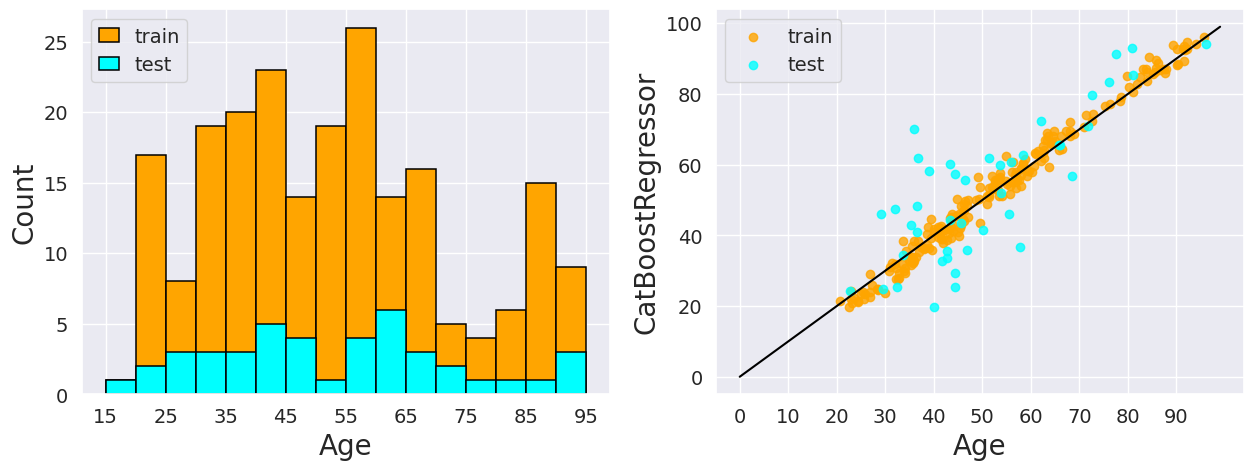

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

train = axs[0].hist(immunology['Age'].loc[immunology['Fold'] != 5], bins=np.arange(15, 100, 5), color='orange', edgecolor='black', linewidth=1.1, label='train')
test = axs[0].hist(immunology['Age'].loc[immunology['Fold'] == 5], bins=np.arange(15, 100, 5), color='cyan', edgecolor='black', linewidth=1.1, label='test')

axs[0].set_xticks(np.arange(15, 100, 10))
axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[0].set_xlabel('Age', fontsize=20)
axs[0].set_ylabel('Count', fontsize=20)
axs[0].legend(handlelength=1, fontsize=14, loc='upper left')

train = axs[1].scatter(predictions_train, y_train, color='orange', alpha=0.8)
test = axs[1].scatter(predictions_test, y_test, color='cyan', alpha=0.8)

axs[1].plot((lambda y: y)(np.arange(0, 100)), np.arange(0, 100), color='black')
axs[1].legend([train, test], ['train', 'test'], fontsize=14)
axs[1].xaxis.set_ticks(np.arange(0, 100, 10))
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)
axs[1].set_xlabel('Age', fontsize=20)
axs[1].set_ylabel('CatBoostRegressor', fontsize=20)

plt.show()

In [65]:
mae_train = predictions_train - y_train.to_numpy().flatten()
mae_test = predictions_test - y_test.to_numpy().flatten()

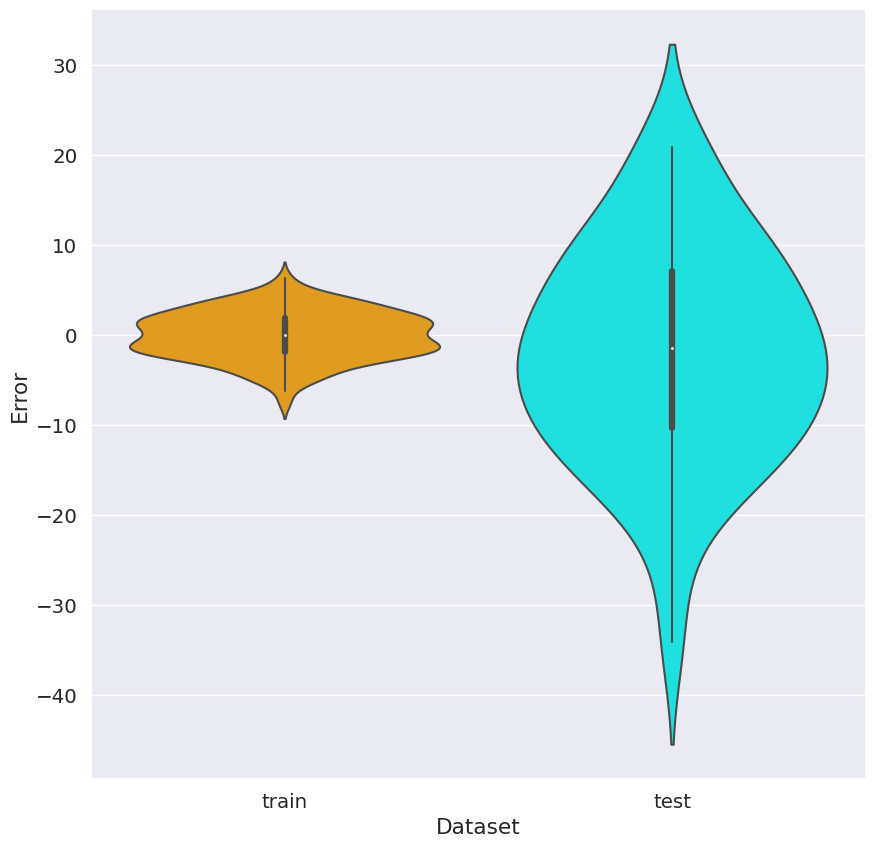

In [70]:
plt.figure(figsize=(10, 10))

immunology_copy = immunology.copy()
immunology_copy.head()

error = np.concatenate((mae_train, mae_test))
indexes = ['train' for i in range(217)]
indexes.extend(['test' for i in range(43)])

immunology_copy['Dataset'] = indexes
immunology_copy['Error'] = error

sns.set(font_scale = 1.3)

sns.violinplot(data=immunology_copy, x='Dataset', y='Error', palette= {'train': 'orange', 'test': 'cyan'}, scale='width', order=['train', 'test'])
plt.show()

# LightGBM

In [ ]:
with open('./logs/params/lightgbm.log', 'r') as f:
    data = f.read()

params = json.loads(data)

X_train = immunology[features].loc[(immunology['Fold'] != immunology['Fold'].max())]
y_train = immunology[target].loc[(immunology['Fold'] != immunology['Fold'].max())]

X_test = immunology[features].loc[immunology['Fold'] == immunology['Fold'].max()]
y_test = immunology[target].loc[immunology['Fold'] == immunology['Fold'].max()]

rgs = LGBMRegressor(**params, silent=True)

predictions_train, predictions_test = train_test_fit_like_models(rgs, X_train, y_train, X_test, y_test, None)

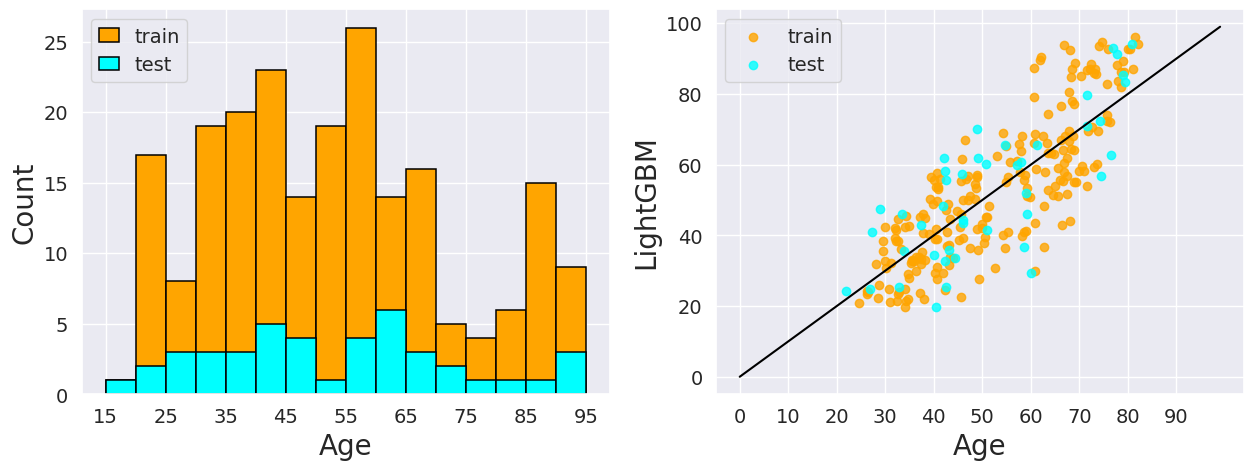

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

train = axs[0].hist(immunology['Age'].loc[immunology['Fold'] != 5], bins=np.arange(15, 100, 5), color='orange', edgecolor='black', linewidth=1.1, label='train')
test = axs[0].hist(immunology['Age'].loc[immunology['Fold'] == 5], bins=np.arange(15, 100, 5), color='cyan', edgecolor='black', linewidth=1.1, label='test')

axs[0].set_xticks(np.arange(15, 100, 10))
axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[0].set_xlabel('Age', fontsize=20)
axs[0].set_ylabel('Count', fontsize=20)
axs[0].legend(handlelength=1, fontsize=14, loc='upper left')

train = axs[1].scatter(predictions_train, y_train, color='orange', alpha=0.8)
test = axs[1].scatter(predictions_test, y_test, color='cyan', alpha=0.8)

axs[1].plot((lambda y: y)(np.arange(0, 100)), np.arange(0, 100), color='black')
axs[1].legend([train, test], ['train', 'test'], fontsize=14)
axs[1].xaxis.set_ticks(np.arange(0, 100, 10))
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)
axs[1].set_xlabel('Age', fontsize=20)
axs[1].set_ylabel('LightGBM', fontsize=20)

plt.show()

In [73]:
mae_train = predictions_train - y_train.to_numpy().flatten()
mae_test = predictions_test - y_test.to_numpy().flatten()

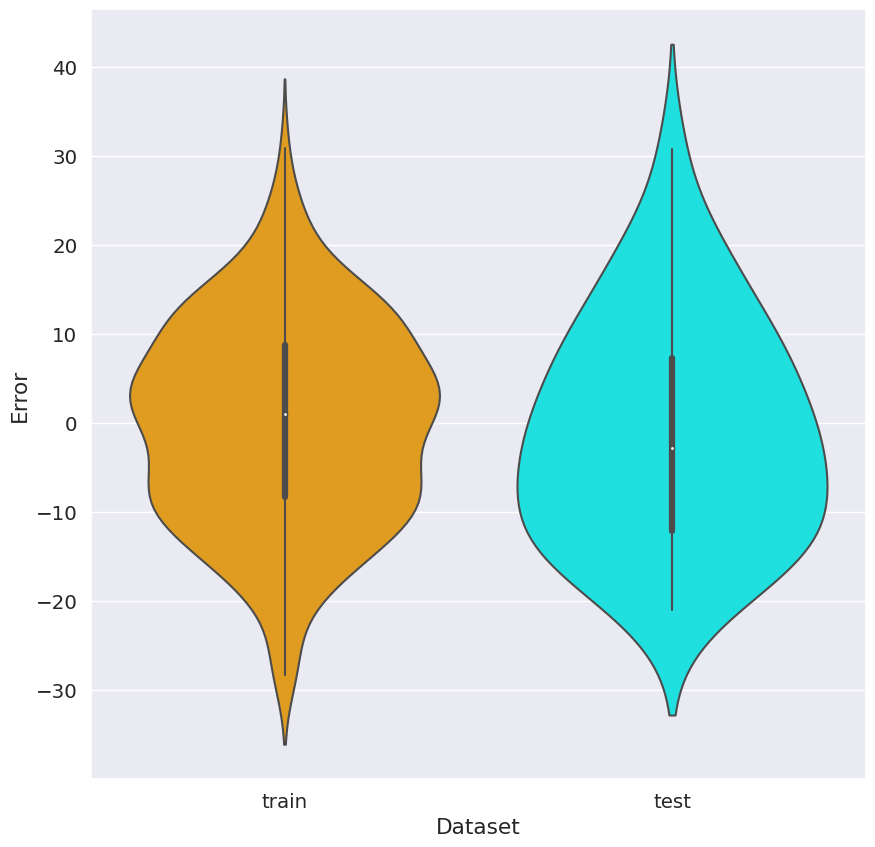

In [74]:
plt.figure(figsize=(10, 10))

immunology_copy = immunology.copy()
immunology_copy.head()

error = np.concatenate((mae_train, mae_test))
indexes = ['train' for i in range(217)]
indexes.extend(['test' for i in range(43)])

immunology_copy['Dataset'] = indexes
immunology_copy['Error'] = error

sns.set(font_scale = 1.3)

sns.violinplot(data=immunology_copy, x='Dataset', y='Error', palette= {'train': 'orange', 'test': 'cyan'}, scale='width', order=['train', 'test'])
plt.show()

# XGBoost

In [ ]:
with open('./logs/params/xgboost.log', 'r') as f:
    data = f.read()

params = json.loads(data)

X_train = immunology[features].loc[(immunology['Fold'] != immunology['Fold'].max())]
y_train = immunology[target].loc[(immunology['Fold'] != immunology['Fold'].max())]

X_test = immunology[features].loc[immunology['Fold'] == immunology['Fold'].max()]
y_test = immunology[target].loc[immunology['Fold'] == immunology['Fold'].max()]

rgs = XGBRegressor(**params)

predictions_train, predictions_test = train_test_fit_like_models(rgs, X_train, y_train, X_test, y_test, None)

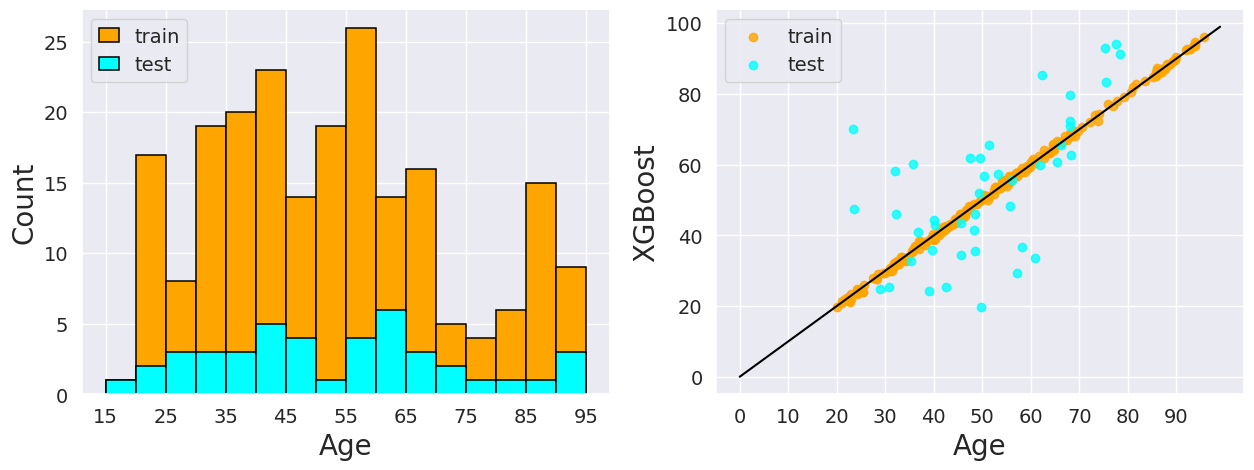

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

train = axs[0].hist(immunology['Age'].loc[immunology['Fold'] != 5], bins=np.arange(15, 100, 5), color='orange', edgecolor='black', linewidth=1.1, label='train')
test = axs[0].hist(immunology['Age'].loc[immunology['Fold'] == 5], bins=np.arange(15, 100, 5), color='cyan', edgecolor='black', linewidth=1.1, label='test')

axs[0].set_xticks(np.arange(15, 100, 10))
axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[0].set_xlabel('Age', fontsize=20)
axs[0].set_ylabel('Count', fontsize=20)
axs[0].legend(handlelength=1, fontsize=14, loc='upper left')

train = axs[1].scatter(predictions_train, y_train, color='orange', alpha=0.8)
test = axs[1].scatter(predictions_test, y_test, color='cyan', alpha=0.8)

axs[1].plot((lambda y: y)(np.arange(0, 100)), np.arange(0, 100), color='black')
axs[1].legend([train, test], ['train', 'test'], fontsize=14)
axs[1].xaxis.set_ticks(np.arange(0, 100, 10))
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)
axs[1].set_xlabel('Age', fontsize=20)
axs[1].set_ylabel('XGBoost', fontsize=20)

plt.show()

In [77]:
mae_train = predictions_train - y_train.to_numpy().flatten()
mae_test = predictions_test - y_test.to_numpy().flatten()

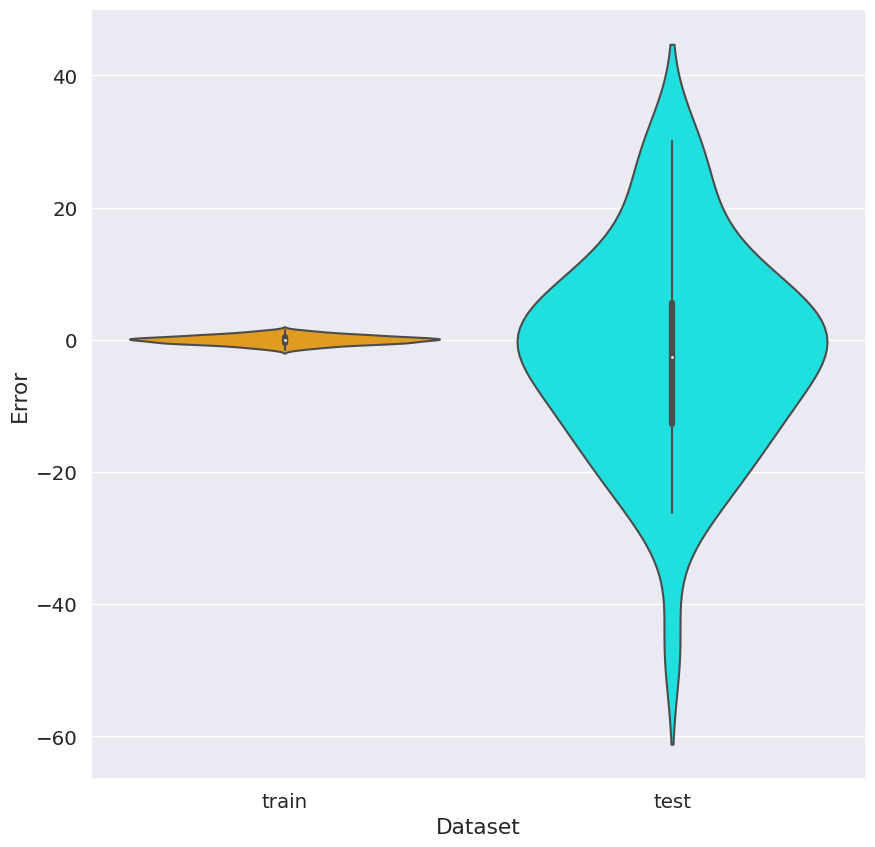

In [78]:
plt.figure(figsize=(10, 10))

immunology_copy = immunology.copy()
immunology_copy.head()

error = np.concatenate((mae_train, mae_test))
indexes = ['train' for i in range(217)]
indexes.extend(['test' for i in range(43)])

immunology_copy['Dataset'] = indexes
immunology_copy['Error'] = error

sns.set(font_scale = 1.3)

sns.violinplot(data=immunology_copy, x='Dataset', y='Error', palette= {'train': 'orange', 'test': 'cyan'}, scale='width', order=['train', 'test'])
plt.show()